# Preparateions

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cv2
from osgeo import gdal, ogr

In [31]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#RUN

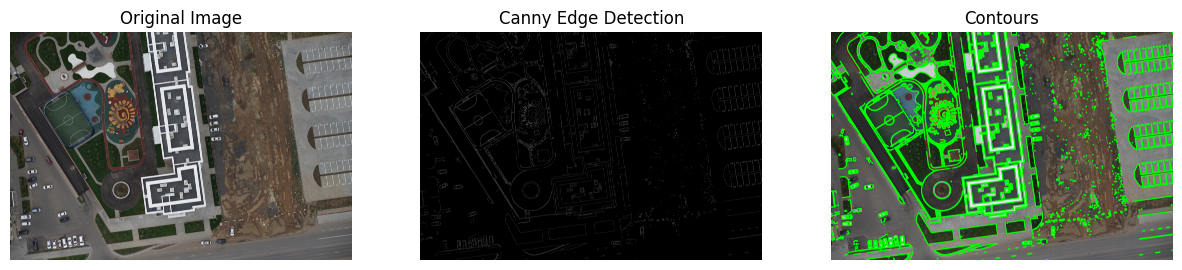

In [32]:
img = cv2.imread('/content/drive/MyDrive/Data/DSC01050.JPG')
archived_img = img
img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (11,11), 0)

high_thresh, thresh_im = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
lowThresh = 0.5 * high_thresh
edges = cv2.Canny(blurred, lowThresh, high_thresh, 5)

contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contour_img = img.copy()
cv2.drawContours(contour_img, contours, -1, (0, 255, 0), 20)

plt.figure(figsize=(15, 5))

# Original
plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

# Canny edge
plt.subplot(1, 3, 2)
plt.imshow(edges, cmap='gray')
plt.title('Canny Edge Detection')
plt.axis('off')

# Contours
plt.subplot(1, 3, 3)
plt.imshow(cv2.cvtColor(contour_img, cv2.COLOR_BGR2RGB))
plt.title('Contours')
plt.axis('off')

plt.show()


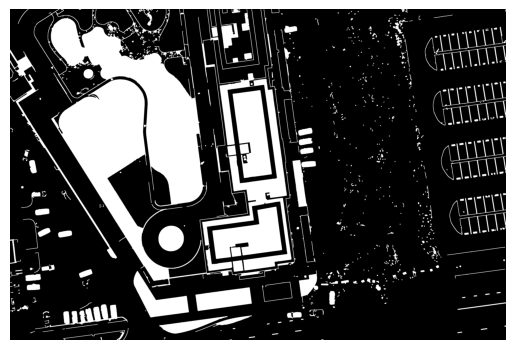

In [33]:
kernel = np.ones((5, 5), np.uint8)
dilated = cv2.dilate(edges, kernel, iterations=2)
eroded = cv2.erode(dilated, kernel, iterations=1)
contours, _ = cv2.findContours(eroded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# black and white contours
contour_img = np.zeros_like(img)
cv2.drawContours(contour_img, contours, -1, (255, 255, 255), thickness=cv2.FILLED)


# using GDAL
driver = gdal.GetDriverByName('GTiff')
ds = driver.Create('/content/drive/MyDrive/Data/contours.tif', img.shape[1], img.shape[0], 1, gdal.GDT_Byte)
ds.GetRasterBand(1).WriteArray(contour_img[:, :, 0])
ds.FlushCache()
ds = None

# polygonizing - making shapes colored
src_ds = gdal.Open('/content/drive/MyDrive/Data/contours.tif')
vector_ds = ogr.GetDriverByName("Memory").CreateDataSource("mem_data")
vector_layer = vector_ds.CreateLayer("contours", geom_type=ogr.wkbPolygon)
gdal.Polygonize(src_ds.GetRasterBand(1), None, vector_layer, 0, [], callback=None)

output_ds = None
vector_ds = None
src_ds = None


dataset = gdal.Open(r'/content/drive/MyDrive/Data/contours.tif')
band1 = dataset.GetRasterBand(1)
b1 = band1.ReadAsArray()
img = band1.ReadAsArray()
plt.imsave('Tiff.png', b1, cmap='gray')

# ouput tif image as P
plt.figure()
plt.imshow(b1, cmap='gray')
plt.axis('off')
plt.show()


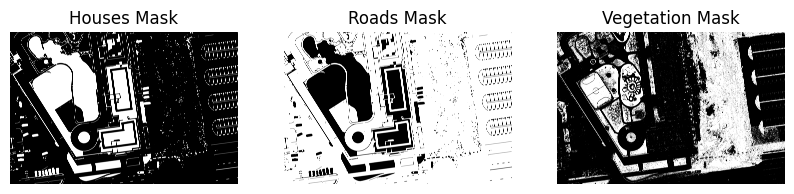

In [34]:
# greens
lower_green = np.array([35, 40, 40])
upper_green = np.array([100, 255, 255])
lower_brown = np.array([10, 40, 40])
upper_brown = np.array([30, 255, 255])
green_mask = cv2.inRange(img_hsv, lower_green, upper_green)
brown_mask = cv2.inRange(img_hsv, lower_brown, upper_brown)

vegetation_mask = cv2.bitwise_or(green_mask, brown_mask)

#houses
_, houses_mask = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

#roads
_, roads_mask = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
roads_mask = cv2.bitwise_not(roads_mask)


plt.figure(figsize=(10, 5))

plt.subplot(131)
plt.imshow(houses_mask, cmap='gray')
plt.title('Houses Mask')
plt.axis('off')

plt.subplot(132)
plt.imshow(roads_mask, cmap='gray')
plt.title('Roads Mask')
plt.axis('off')

plt.subplot(133)
plt.imshow(vegetation_mask, cmap='gray')
plt.title('Vegetation Mask')
plt.axis('off')

plt.show()


houses_contours, _ = cv2.findContours(houses_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
roads_contours, _ = cv2.findContours(roads_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
vegetation_contours, _ = cv2.findContours(vegetation_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

houses_polygons = [contour for contour in houses_contours]
roads_polygons = [contour for contour in roads_contours]
vegetation_polygons = [contour for contour in vegetation_contours]


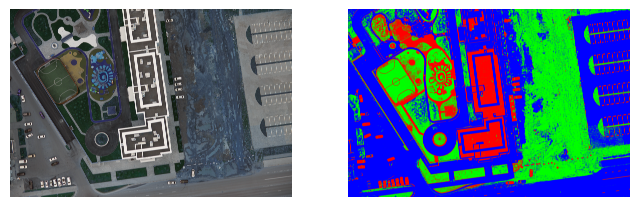

In [35]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def connect_masks(houses_mask, roads_mask, vegetation_mask):
    connected_img = np.zeros((houses_mask.shape[0], houses_mask.shape[1], 3), dtype=np.uint8)

    # RGB
    connected_img[houses_mask == 255] = [0, 0, 255]
    connected_img[roads_mask == 255] = [255, 0, 0]
    connected_img[vegetation_mask == 255] = [0, 255, 0]

    return connected_img


houses_mask = cv2.threshold(houses_mask, 0, 255, cv2.THRESH_BINARY)[1]
roads_mask = cv2.threshold(roads_mask, 0, 255, cv2.THRESH_BINARY)[1]

connected_img = connect_masks(houses_mask, roads_mask, vegetation_mask)


plt.figure(figsize=(8, 4))

plt.subplot(121)
plt.imshow(archived_img)
plt.axis('off')

plt.subplot(122)
colors = {'Cars, buildings, etc.': 'red', 'Roads and paveways': 'blue', 'Vegetation and ground': 'green'}
legend_labels = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=label) for label, color in colors.items()]
plt.legend(handles=legend_labels, loc='upper left', bbox_to_anchor=(1, 1))

plt.imshow(cv2.cvtColor(connected_img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()
